In [1]:
from typing import Dict, List, Optional, Tuple

import gymnasium as gym
import numpy as np
from numpy import typing as npt

In [2]:
"""Environment for Modified Travelling Salesman Problem."""

from typing import Dict, List, Optional, Tuple

import gymnasium as gym
import numpy as np
from numpy import typing as npt


class ModTSP(gym.Env):
    """Travelling Salesman Problem (TSP) RL environment for maximizing profits.

    The agent navigates a set of targets based on precomputed distances. It aims to visit
    all targets so maximize profits. The profits decay with time.
    """

    def __init__(
        self,
        num_targets: int = 10,
        max_area: int = 15,
        shuffle_time: int = 10,
        seed: int = 42,
    ) -> None:
        """Initialize the TSP environment.

        Args:
            num_targets (int): No. of targets the agent needs to visit.
            max_area (int): Max. Square area where the targets are defined.
            shuffle_time (int): No. of episodes after which the profits ar to be shuffled.
            seed (int): Random seed for reproducibility.
        """
        super().__init__()

        np.random.seed(seed)

        self.steps: int = 0
        self.episodes: int = 0

        self.shuffle_time: int = shuffle_time
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: npt.NDArray[np.float32] = self._generate_points(self.num_targets)
        print("self.locations: ", self.locations)
        print("self.locations.shape: ", self.locations.shape)
        print('\n')
        self.distances: npt.NDArray[np.float32] = self._calculate_distances(self.locations)
        print("self.distances: ", self.distances)
        print("self.distances.shape: ", self.distances.shape)
        print('\n')

        # Initialize profits for each target
        self.initial_profits: npt.NDArray[np.float32] = np.arange(1, self.num_targets + 1, dtype=np.float32) * 10.0
        print("self.initial_profits: ", self.initial_profits)
        print("self.initial_profits.shape: ", self.initial_profits.shape)
        print('\n')
        self.current_profits: npt.NDArray[np.float32] = self.initial_profits.copy()
        print("self.current_profits: ", self.current_profits)
        print("self.current_profits.shape: ", self.current_profits.shape)
        print('\n')

        # Observation Space : {current loc (loc), target flag - visited or not, current profits, dist_array (distances), coordintates (locations)}
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),  # Current location
                np.zeros(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                np.zeros(self.num_targets, dtype=np.float32),  # Array of all current profits values
                np.zeros(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                np.zeros(2 * self.num_targets, dtype=np.float32),  # Cooridinates of all targets
            ]
        )
        print("self.obs_low: ", self.obs_low)
        print('\n')

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),  # Current location
                np.ones(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                100 * np.ones(self.num_targets, dtype=np.float32),  # Array of all current profits values
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),  # Cooridinates of all targets
            ]
        )
        print("self.obs_high: ", self.obs_high)
        print('\n')

        # Action Space : {next_target}
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        print("self.observation_space: ", self.observation_space)
        print("self.observation_space.shape: ", self.observation_space.shape)
        print('\n')

        self.action_space = gym.spaces.Discrete(self.num_targets)
        print("self.action_space: ", self.action_space)
        print("self.action_space.shape: ", self.action_space.shape) 
        print('\n')

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[np.ndarray, Dict[str, None]]:
        """Reset the environment to the initial state.

        Args:
            seed (Optional[int], optional): Seed to reset the environment. Defaults to None.
            options (Optional[dict], optional): Additional reset options. Defaults to None.

        Returns:
            Tuple[np.ndarray, Dict[str, None]]: The initial state of the environment and an empty info dictionary.
        """
        self.steps: int = 0
        self.episodes += 1

        self.loc: int = 0
        self.visited_targets: npt.NDArray[np.float32] = np.zeros(self.num_targets)
        self.current_profits = self.initial_profits.copy()
        self.dist: List = self.distances[self.loc]

        if self.shuffle_time % self.episodes == 0:
            np.random.shuffle(self.initial_profits)

        state = np.concatenate(
            (
                np.array([self.loc]),
                self.visited_targets,
                self.initial_profits,
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """Take an action (move to the next target).

        Args:
            action (int): The index of the next target to move to.

        Returns:
            Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
                - The new state of the environment.
                - The reward for the action.
                - A boolean indicating whether the episode has terminated.
                - A boolean indicating if the episode is truncated.
                - An empty info dictionary.
        """
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        self.current_profits -= self.distances[past_loc, next_loc]
        reward = self._get_rewards(next_loc)

        self.visited_targets[next_loc] = 1

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                self.visited_targets,
                self.current_profits,
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> npt.NDArray[np.float32]:
        """Generate random 2D points representing target locations.

        Args:
            num_points (int): Number of points to generate.

        Returns:
            np.ndarray: Array of 2D coordinates for each target.
        """
        return np.random.uniform(low=0, high=self.max_area, size=(num_points, 2)).astype(np.float32)

    def _calculate_distances(self, locations: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        """Calculate the distance matrix between all target locations.

        Args:
            locations: List of 2D target locations.

        Returns:
            np.ndarray: Matrix of pairwise distances between targets.
        """
        n = len(locations)

        distances = np.zeros((n, n), dtype=np.float32)
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, next_loc: int) -> float:
        """Calculate the reward based on the distance traveled, however if a target gets visited again then it incurs a high penalty.

        Args:
            next_loc (int): Next location of the agent.

        Returns:
            float: Reward based on the travel distance between past and next locations, or negative reward if repeats visit.
        """
        reward = self.current_profits[next_loc] if not self.visited_targets[next_loc] else -1e4
        return float(reward)


def main() -> None:
    """Main function."""
    num_targets = 10

    env = ModTSP(num_targets)
    obs = env.reset()
    ep_rets = []

    for ep in range(100):
        ret = 0
        obs = env.reset()
        for _ in range(100):
            action = env.action_space.sample()  # You need to replace this with your algorithm that predicts the action.

            obs_, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            ret += reward

            if done:
                break

        ep_rets.append(ret)
        # print(f"Episode {ep} : {ret}")

    print(np.mean(ep_rets))


if __name__ == "__main__":
    main()


self.locations:  [[ 5.6181016 14.260715 ]
 [10.979909   8.979877 ]
 [ 2.3402796  2.339918 ]
 [ 0.8712542 12.992642 ]
 [ 9.016726  10.621089 ]
 [ 0.3087674 14.548648 ]
 [12.48664    3.1850867]
 [ 2.7273746  2.7510676]
 [ 4.5636334  7.8713465]
 [ 6.479175   4.3684373]]
self.locations.shape:  (10, 2)


self.distances:  [[ 0.         7.5257034 12.363232   4.913305   4.9797106  5.317136
  13.032512  11.867109   6.4757957  9.929682 ]
 [ 7.5257034  0.        10.896433  10.875991   2.5588405 12.036797
   5.9874735 10.339362   6.511331   6.4437556]
 [12.363232  10.896433   0.        10.753538  10.637327  12.376596
  10.1814995  0.5647005  5.9615436  4.6092677]
 [ 4.913305  10.875991  10.753538   0.         8.483689   1.6545527
  15.202149  10.408412   6.3135834 10.287161 ]
 [ 4.9797106  2.5588405 10.637327   8.483689   0.         9.55271
   8.205756  10.074382   5.233652   6.747949 ]
 [ 5.317136  12.036797  12.376596   1.6545527  9.55271    0.
  16.656263  12.042947   7.917717  11.904227 ]
 [13

Episode 0 : -29845.859023094177


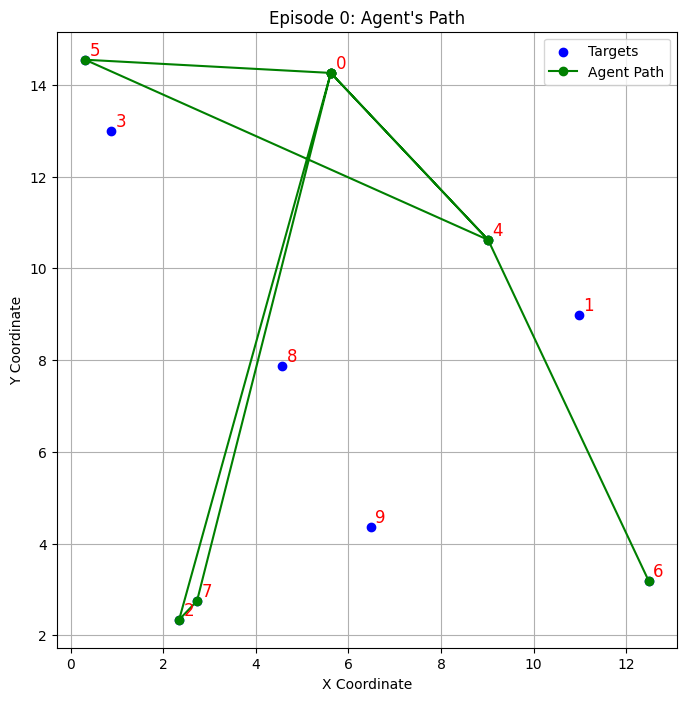

Episode 1 : -39837.410853385925


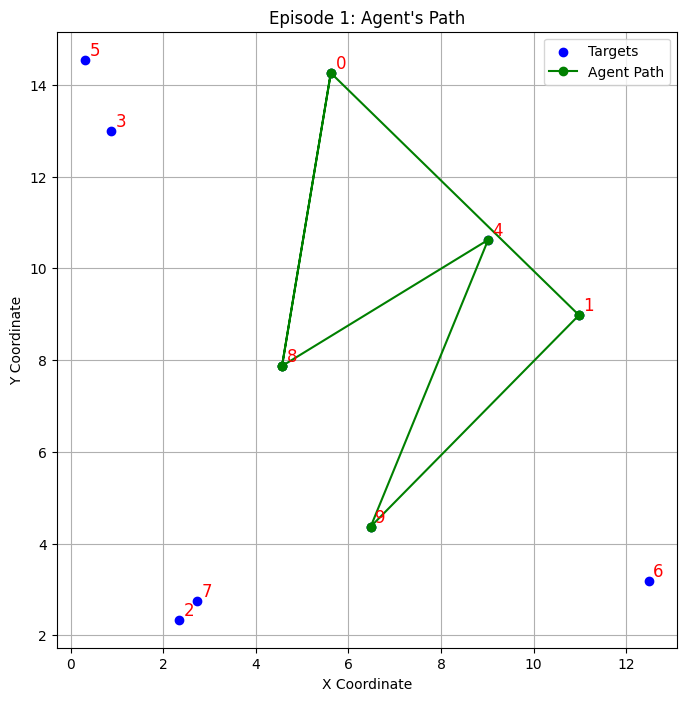

Episode 2 : -29823.843482017517


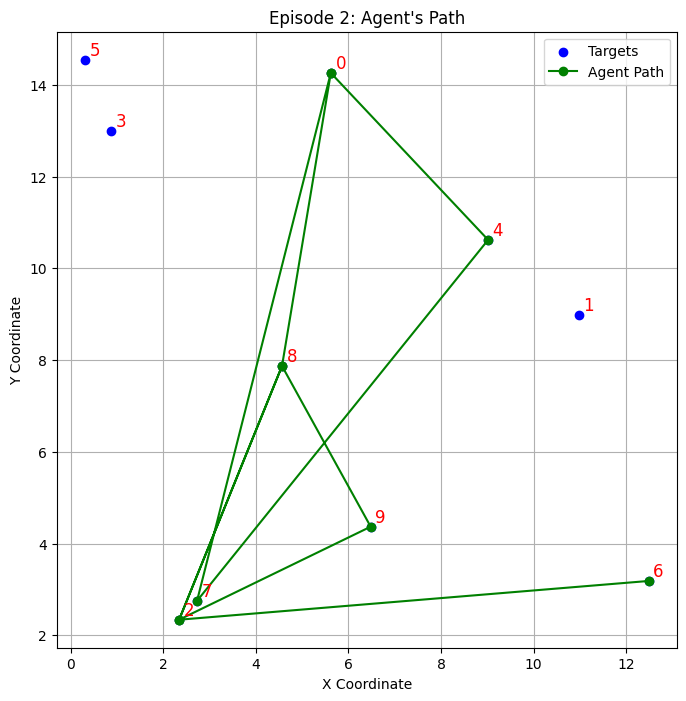

Episode 3 : -19894.89810848236


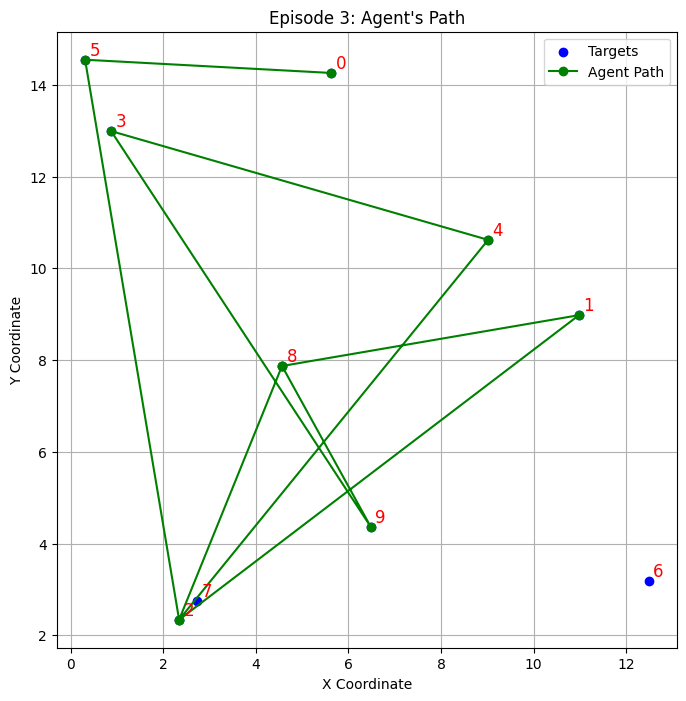

Episode 4 : -39846.948800086975


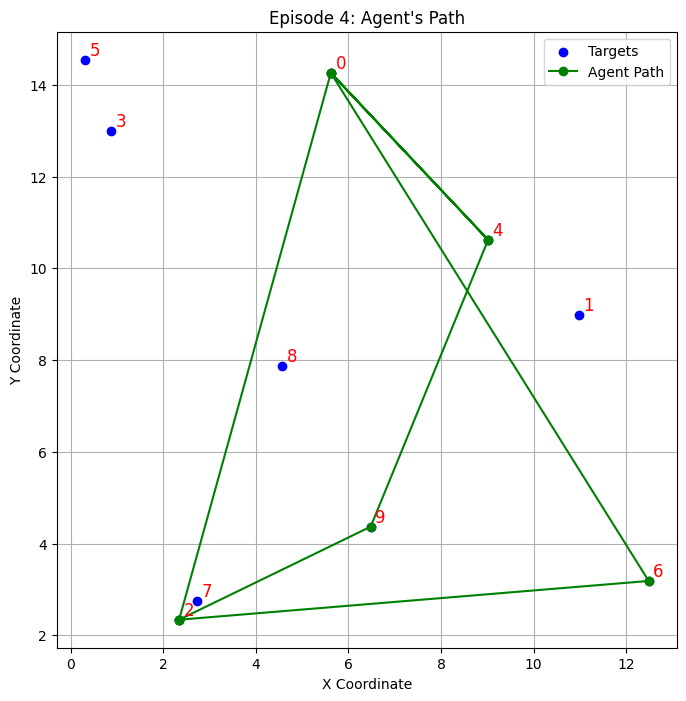

Episode 5 : -19896.266196250916


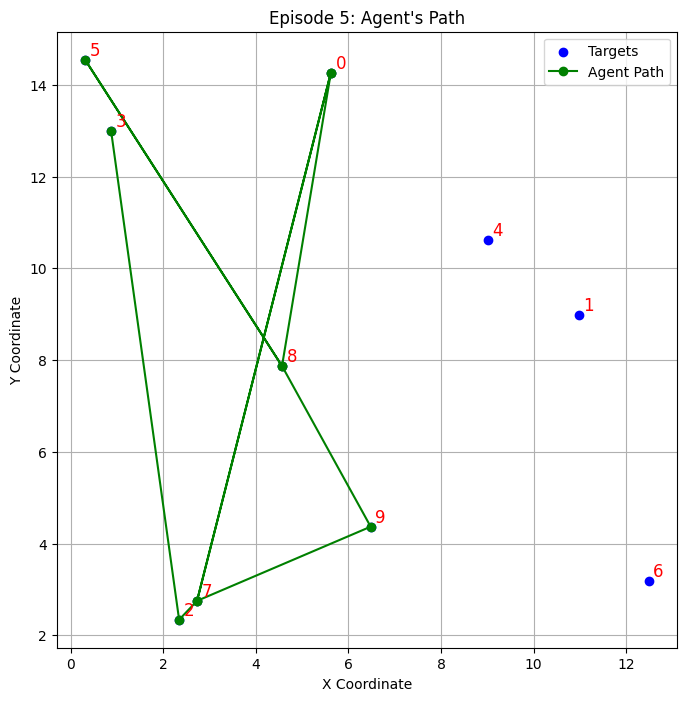

Episode 6 : -39907.753403663635


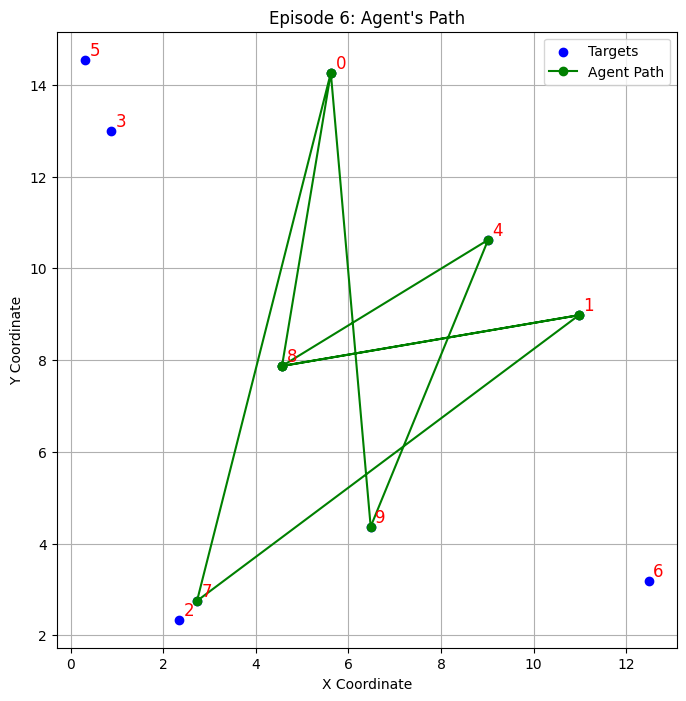

Episode 7 : -49802.93283200264


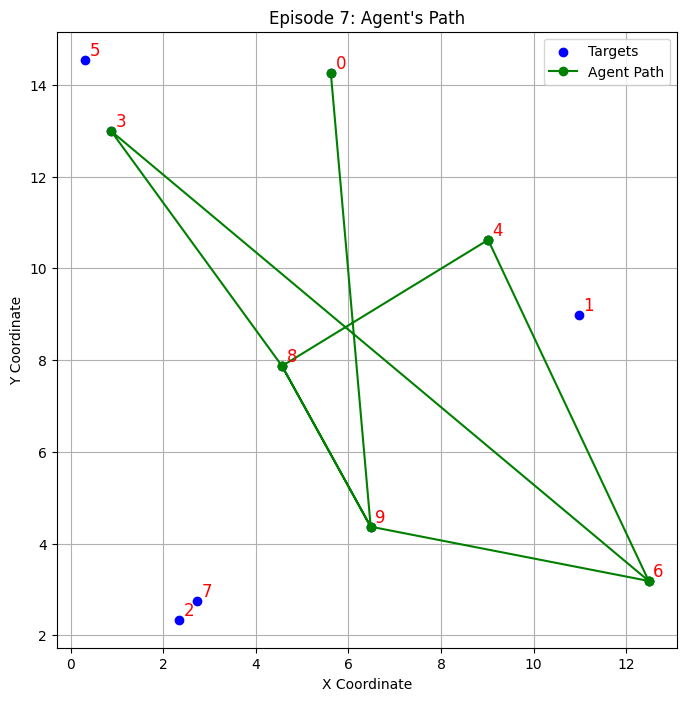

Episode 8 : -39838.96685600281


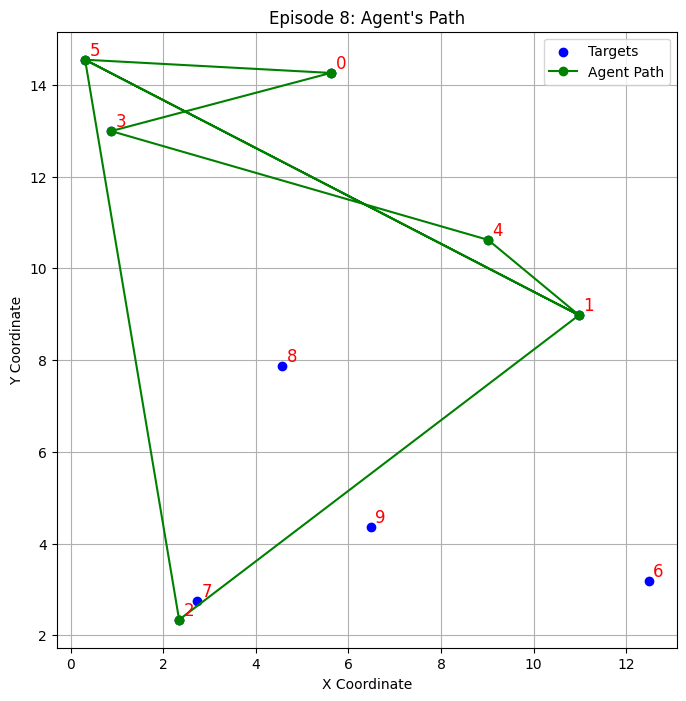

Episode 9 : -29780.564462661743


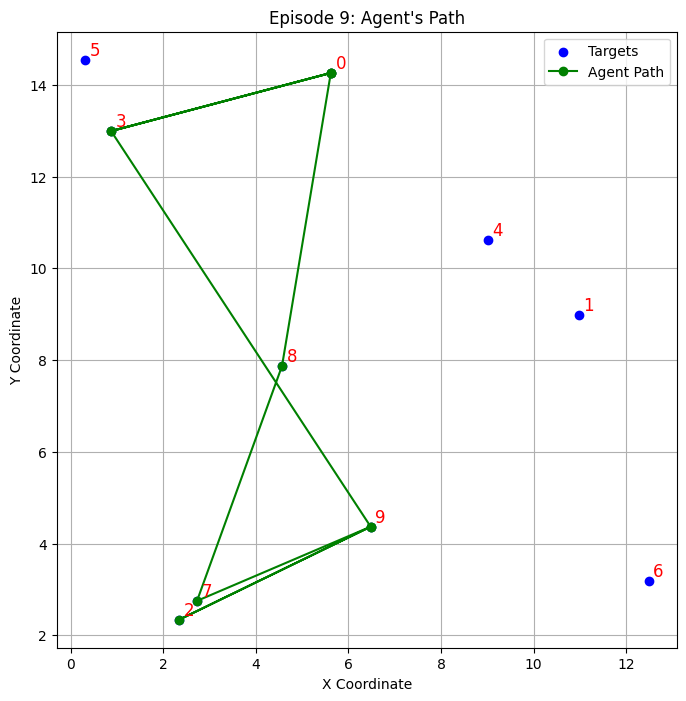

Average return over 10 episodes: -33847.54440176487
Episode 0 : -39837.996631622314


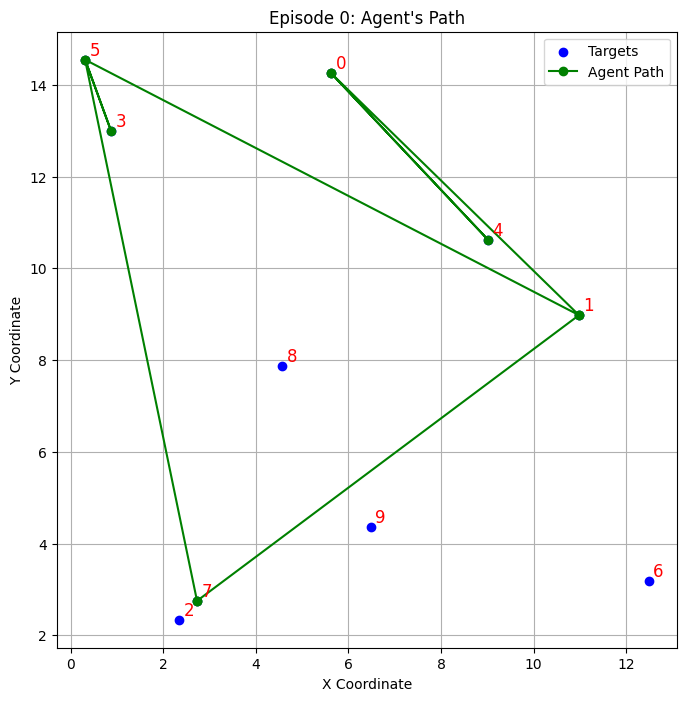

Episode 1 : -39855.38176488876


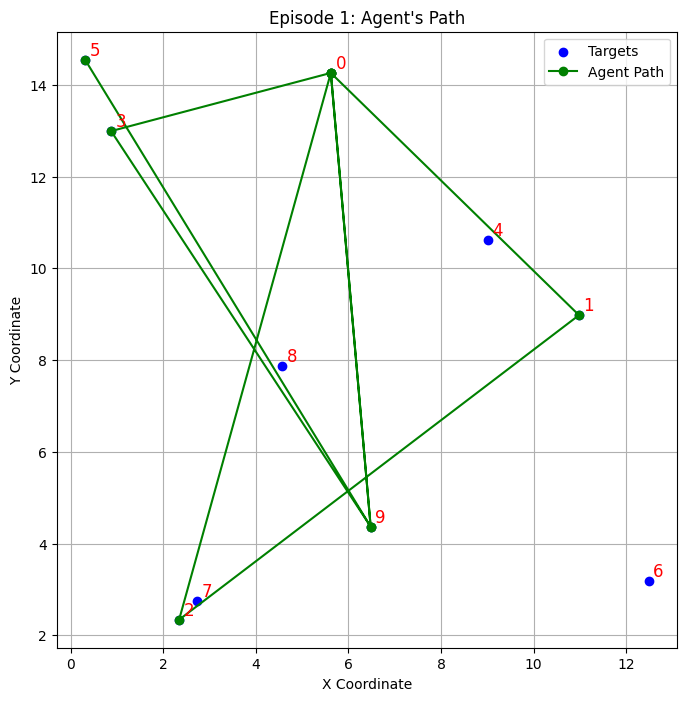

Episode 2 : -29885.489778518677


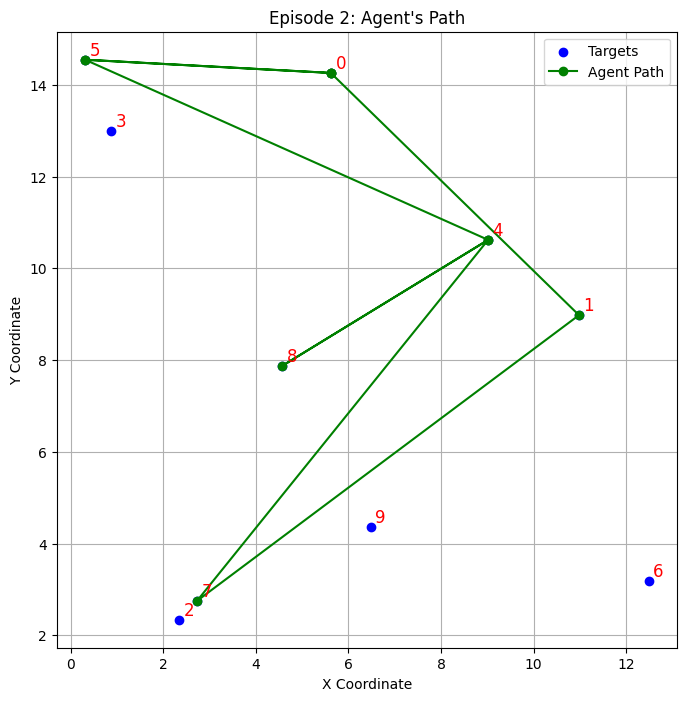

Episode 3 : -29861.745705127716


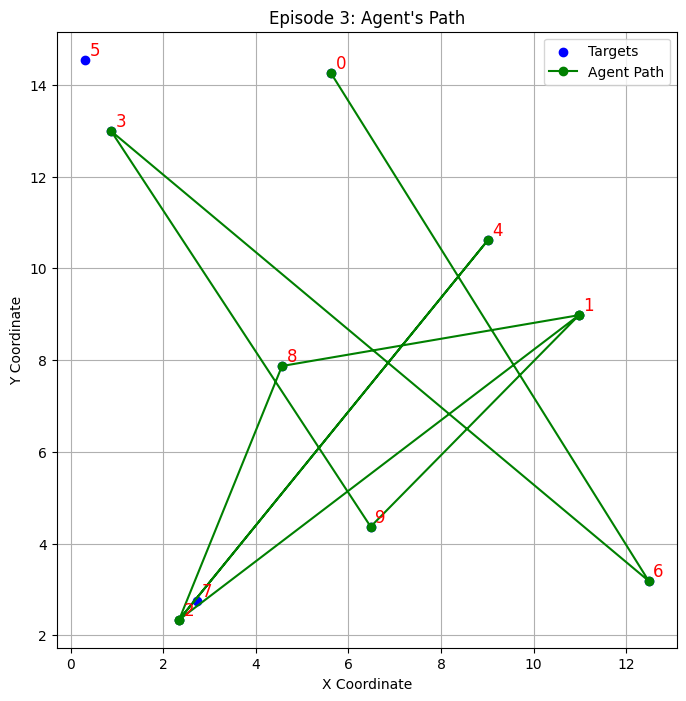

Episode 4 : -49803.874492645264


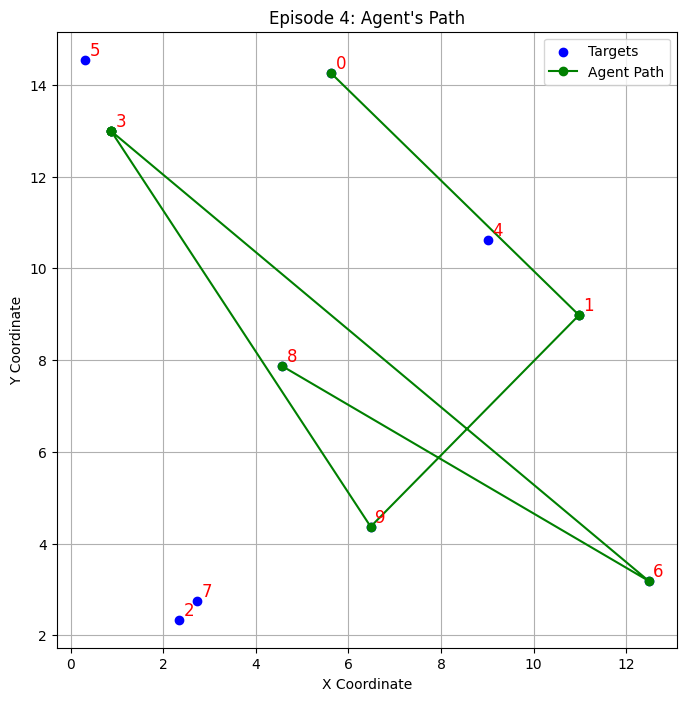

Episode 5 : -29881.769670009613


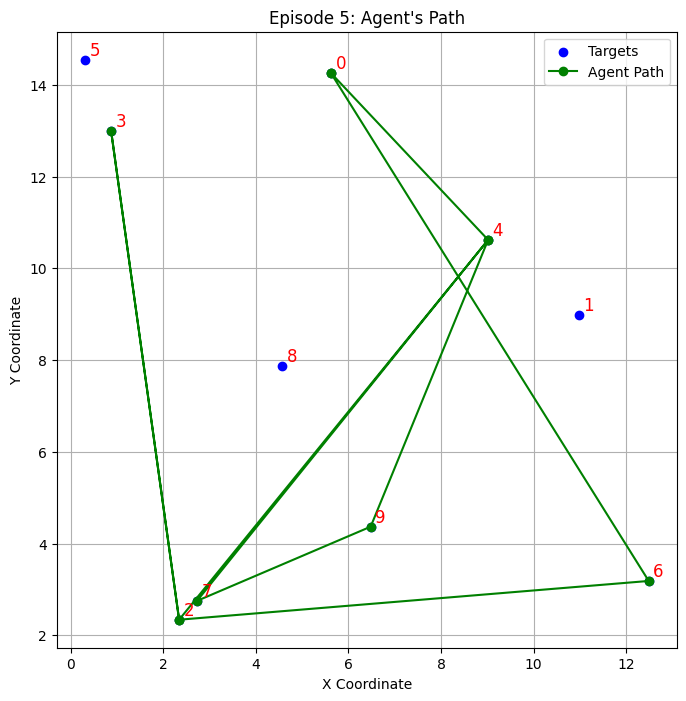

Episode 6 : -39932.287601947784


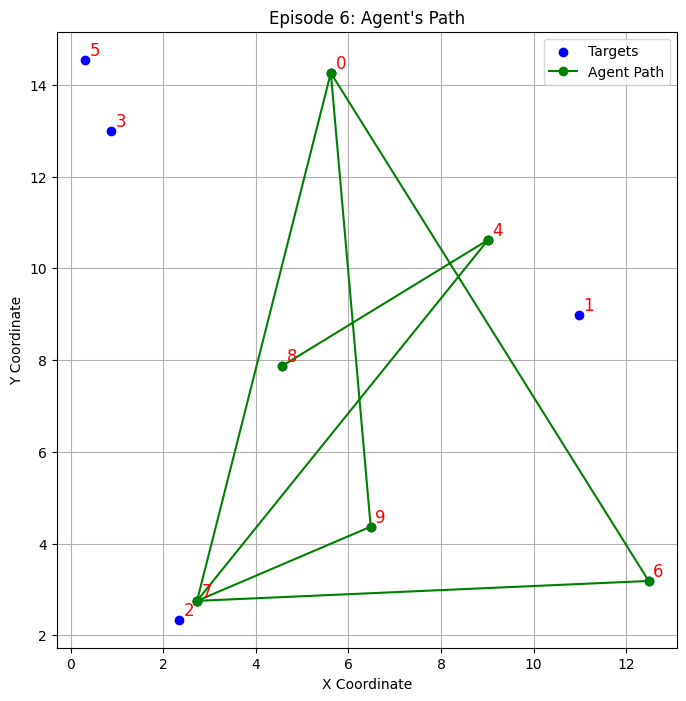

Episode 7 : -29932.831181526184


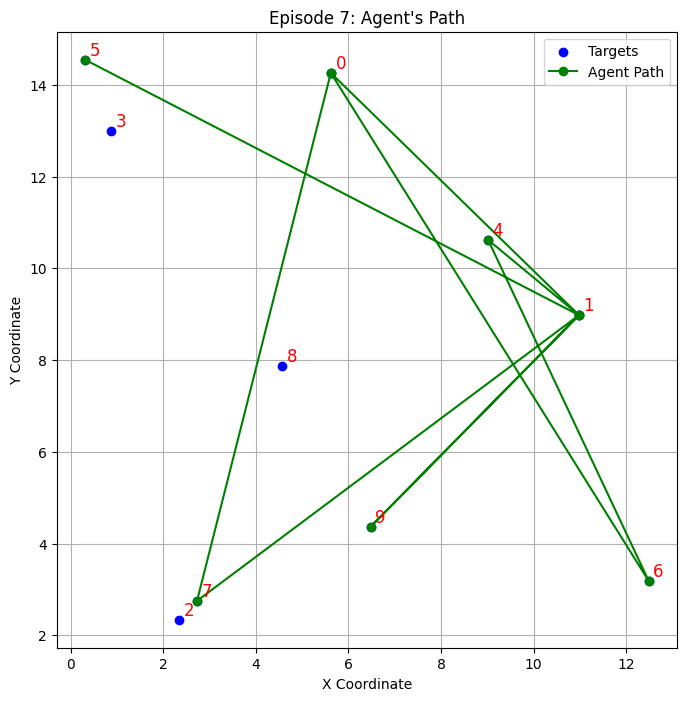

Episode 8 : -39818.63597488403


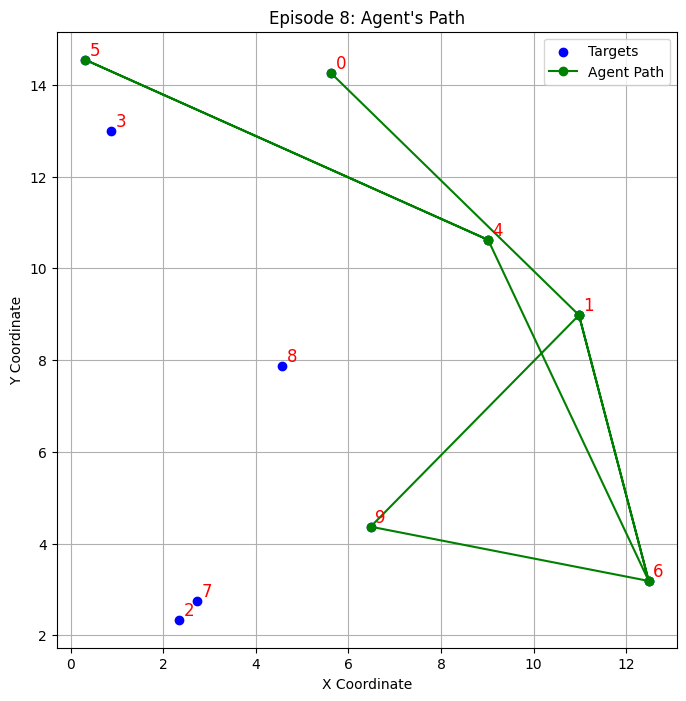

Episode 9 : -39876.206731796265


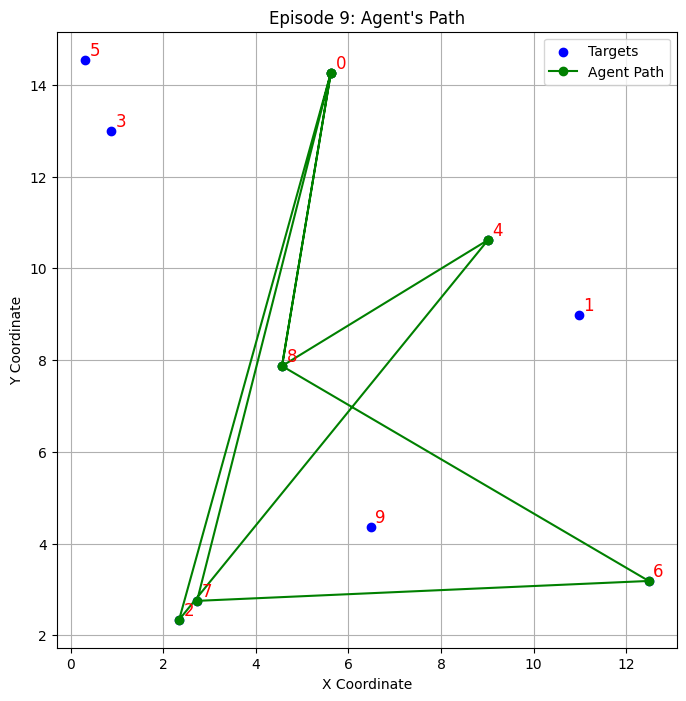

Average return over 10 episodes: -36868.621953296664


In [3]:
from typing import Dict, List, Optional, Tuple

import gymnasium as gym
import numpy as np
from numpy import typing as npt
import matplotlib.pyplot as plt

class ModTSP(gym.Env):
    """Travelling Salesman Problem (TSP) RL environment for maximizing profits.

    The agent navigates a set of targets based on precomputed distances. It aims to visit
    all targets so maximize profits. The profits decay with time.
    """

    def __init__(
        self,
        num_targets: int = 10,
        max_area: int = 15,
        shuffle_time: int = 10,
        seed: int = 42,
    ) -> None:
        """Initialize the TSP environment.

        Args:
            num_targets (int): No. of targets the agent needs to visit.
            max_area (int): Max. Square area where the targets are defined.
            shuffle_time (int): No. of episodes after which the profits are to be shuffled.
            seed (int): Random seed for reproducibility.
        """
        super().__init__()

        np.random.seed(seed)

        self.steps: int = 0
        self.episodes: int = 0

        self.shuffle_time: int = shuffle_time
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: npt.NDArray[np.float32] = self._generate_points(self.num_targets)
        self.distances: npt.NDArray[np.float32] = self._calculate_distances(self.locations)

        # Initialize profits for each target
        self.initial_profits: npt.NDArray[np.float32] = np.arange(1, self.num_targets + 1, dtype=np.float32) * 10.0
        self.current_profits: npt.NDArray[np.float32] = self.initial_profits.copy()

        # Observation Space : {current loc (loc), target flag - visited or not, current profits, dist_array (distances), coordintates (locations)}
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),  # Current location
                np.zeros(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                np.zeros(self.num_targets, dtype=np.float32),  # Array of all current profits values
                np.zeros(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                np.zeros(2 * self.num_targets, dtype=np.float32),  # Coordinates of all targets
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),  # Current location
                np.ones(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                100 * np.ones(self.num_targets, dtype=np.float32),  # Array of all current profits values
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),  # Coordinates of all targets
            ]
        )

        # Action Space : {next_target}
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[np.ndarray, Dict[str, None]]:
        """Reset the environment to the initial state.

        Args:
            seed (Optional[int], optional): Seed to reset the environment. Defaults to None.
            options (Optional[dict], optional): Additional reset options. Defaults to None.

        Returns:
            Tuple[np.ndarray, Dict[str, None]]: The initial state of the environment and an empty info dictionary.
        """
        self.steps: int = 0
        self.episodes += 1

        self.loc: int = 0
        self.visited_targets: npt.NDArray[np.float32] = np.zeros(self.num_targets)
        self.current_profits = self.initial_profits.copy()
        self.dist: List = self.distances[self.loc]

        if self.shuffle_time % self.episodes == 0:
            np.random.shuffle(self.initial_profits)

        state = np.concatenate(
            (
                np.array([self.loc]),
                self.visited_targets,
                self.initial_profits,
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """Take an action (move to the next target).

        Args:
            action (int): The index of the next target to move to.

        Returns:
            Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
                - The new state of the environment.
                - The reward for the action.
                - A boolean indicating whether the episode has terminated.
                - A boolean indicating if the episode is truncated.
                - An empty info dictionary.
        """
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        self.current_profits -= self.distances[past_loc, next_loc]
        reward = self._get_rewards(next_loc)

        self.visited_targets[next_loc] = 1

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                self.visited_targets,
                self.current_profits,
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> npt.NDArray[np.float32]:
        """Generate random 2D points representing target locations.

        Args:
            num_points (int): Number of points to generate.

        Returns:
            np.ndarray: Array of 2D coordinates for each target.
        """
        return np.random.uniform(low=0, high=self.max_area, size=(num_points, 2)).astype(np.float32)

    def _calculate_distances(self, locations: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        """Calculate the distance matrix between all target locations.

        Args:
            locations: List of 2D target locations.

        Returns:
            np.ndarray: Matrix of pairwise distances between targets.
        """
        n = len(locations)

        distances = np.zeros((n, n), dtype=np.float32)
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, next_loc: int) -> float:
        """Calculate the reward based on the distance traveled, however if a target gets visited again then it incurs a high penalty.

        Args:
            next_loc (int): Next location of the agent.

        Returns:
            float: Reward based on the travel distance between past and next locations, or negative reward if repeats visit.
        """
        reward = self.current_profits[next_loc] if not self.visited_targets[next_loc] else -1e4
        return float(reward)


def plot_episode(locations, path, episode):
    """Plot the episode's path and target locations.

    Args:
        locations (ndarray): Array of target locations.
        path (list): Sequence of target indices visited by the agent.
        episode (int): The current episode number.
    """
    plt.figure(figsize=(8, 8))
    plt.scatter(locations[:, 0], locations[:, 1], color='blue', label='Targets')

    # Plot the visited path
    path_locs = locations[path]
    plt.plot(path_locs[:, 0], path_locs[:, 1], color='green', linestyle='-', marker='o', label='Agent Path')

    for i, loc in enumerate(locations):
        plt.text(loc[0] + 0.1, loc[1] + 0.1, str(i), color='red', fontsize=12)  # Label targets with index

    plt.title(f"Episode {episode}: Agent's Path")
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()


def main() -> None:
    """Main function."""
    num_targets = 10
    env = ModTSP(num_targets)
    obs, _ = env.reset()
    ep_rets = []

    for ep in range(10):
        ret = 0
        obs, _ = env.reset()
        path = []  # To keep track of the path for plotting

        for _ in range(env.max_steps):
            action = env.action_space.sample()  # Replace this with your algorithm that predicts the action.
            
            # Extract the current location from the observation (first element)
            path.append(int(obs[0]))  # Track the current position

            obs_, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            ret += reward

            if done:
                break

            obs = obs_  # Update observation

        ep_rets.append(ret)
        print(f"Episode {ep} : {ret}")

        # Plot the episode path
        plot_episode(env.locations, path, ep)

    print(f"Average return over 10 episodes: {np.mean(ep_rets)}")


if __name__ == "__main__":
    main()



if __name__ == "__main__":
    main()


In [4]:
from typing import Dict, List, Optional, Tuple
import gymnasium as gym
import numpy as np
from numpy import typing as npt
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Define the ModTSP environment as provided
class ModTSP(gym.Env):
    """Travelling Salesman Problem (TSP) RL environment for maximizing profits.

    The agent navigates a set of targets based on precomputed distances. It aims to visit
    all targets to maximize profits. The profits decay with time.
    """

    def __init__(
        self,
        num_targets: int = 10,
        max_area: int = 15,
        shuffle_time: int = 10,
        seed: int = 42,
    ) -> None:
        """Initialize the TSP environment.

        Args:
            num_targets (int): No. of targets the agent needs to visit.
            max_area (int): Max. Square area where the targets are defined.
            shuffle_time (int): No. of episodes after which the profits are to be shuffled.
            seed (int): Random seed for reproducibility.
        """
        super().__init__()

        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)

        self.steps: int = 0
        self.episodes: int = 0

        self.shuffle_time: int = shuffle_time
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: npt.NDArray[np.float32] = self._generate_points(self.num_targets)
        self.distances: npt.NDArray[np.float32] = self._calculate_distances(self.locations)

        # Initialize profits for each target
        self.initial_profits: npt.NDArray[np.float32] = np.arange(1, self.num_targets + 1, dtype=np.float32) * 10.0
        self.current_profits: npt.NDArray[np.float32] = self.initial_profits.copy()

        # Observation Space : {current loc (loc), target flag - visited or not, current profits, dist_array (distances), coordinates (locations)}
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),  # Current location
                np.zeros(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                np.zeros(self.num_targets, dtype=np.float32),  # Array of all current profits values
                np.zeros(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                np.zeros(2 * self.num_targets, dtype=np.float32),  # Coordinates of all targets
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),  # Current location
                np.ones(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                100 * np.ones(self.num_targets, dtype=np.float32),  # Array of all current profits values
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),  # Coordinates of all targets
            ]
        )

        # Action Space : {next_target}
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high, dtype=np.float32)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[np.ndarray, Dict[str, None]]:
        """Reset the environment to the initial state.

        Args:
            seed (Optional[int], optional): Seed to reset the environment. Defaults to None.
            options (Optional[dict], optional): Additional reset options. Defaults to None.

        Returns:
            Tuple[np.ndarray, Dict[str, None]]: The initial state of the environment and an empty info dictionary.
        """
        self.steps: int = 0
        self.episodes += 1

        self.loc: int = 0
        self.visited_targets: npt.NDArray[np.float32] = np.zeros(self.num_targets)
        self.current_profits = self.initial_profits.copy()
        self.dist: List = self.distances[self.loc]

        if self.shuffle_time != 0 and self.episodes % self.shuffle_time == 0:
            np.random.shuffle(self.initial_profits)

        state = np.concatenate(
            (
                np.array([self.loc]),
                self.visited_targets,
                self.initial_profits,
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """Take an action (move to the next target).

        Args:
            action (int): The index of the next target to move to.

        Returns:
            Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
                - The new state of the environment.
                - The reward for the action.
                - A boolean indicating whether the episode has terminated.
                - A boolean indicating if the episode is truncated.
                - An empty info dictionary.
        """
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        self.current_profits -= self.distances[past_loc, next_loc]
        reward = self._get_rewards(next_loc)

        self.visited_targets[next_loc] = 1

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                self.visited_targets,
                self.current_profits,
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> npt.NDArray[np.float32]:
        """Generate random 2D points representing target locations.

        Args:
            num_points (int): Number of points to generate.

        Returns:
            np.ndarray: Array of 2D coordinates for each target.
        """
        return np.random.uniform(low=0, high=self.max_area, size=(num_points, 2)).astype(np.float32)

    def _calculate_distances(self, locations: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        """Calculate the distance matrix between all target locations.

        Args:
            locations: List of 2D target locations.

        Returns:
            np.ndarray: Matrix of pairwise distances between targets.
        """
        n = len(locations)

        distances = np.zeros((n, n), dtype=np.float32)
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, next_loc: int) -> float:
        """Calculate the reward based on the distance traveled, however if a target gets visited again then it incurs a high penalty.

        Args:
            next_loc (int): Next location of the agent.

        Returns:
            float: Reward based on the travel distance between past and next locations, or negative reward if repeats visit.
        """
        reward = self.current_profits[next_loc] if not self.visited_targets[next_loc] else -1e4
        return float(reward)


# Define the Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return (
            torch.FloatTensor(state),
            torch.LongTensor(action),
            torch.FloatTensor(reward),
            torch.FloatTensor(next_state),
            torch.FloatTensor(done),
        )

    def __len__(self):
        return len(self.buffer)


# Define the Q-Network
class QNetwork(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(QNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )

    def forward(self, x):
        return self.layers(x)


# Define the DQN Agent
class DQNAgent:
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        replay_buffer: ReplayBuffer,
        lr: float = 1e-3,
        gamma: float = 0.99,
        batch_size: int = 64,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.01,
        epsilon_decay: int = 500,
        target_update_freq: int = 10,
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.replay_buffer = replay_buffer
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

        self.steps_done = 0

    def select_action(self, state: np.ndarray) -> int:
        self.steps_done += 1
        # Epsilon decay
        self.epsilon = self.epsilon_min + (1.0 - self.epsilon_min) * np.exp(-1. * self.steps_done / self.epsilon_decay)

        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.policy_net(state)
            return q_values.argmax().item()

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)

        state = state.to(self.device)
        action = action.to(self.device)
        reward = reward.to(self.device)
        next_state = next_state.to(self.device)
        done = done.to(self.device)

        # Current Q Values
        q_values = self.policy_net(state).gather(1, action.unsqueeze(1)).squeeze(1)

        # Target Q Values
        with torch.no_grad():
            next_q_values = self.target_net(next_state).max(1)[0]
            target_q_values = reward + self.gamma * next_q_values * (1 - done)

        # Loss
        loss = self.loss_fn(q_values, target_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())


# Define the plotting function
def plot_episode(locations, path, episode, rewards):
    """Plot the episode's path and target locations.

    Args:
        locations (ndarray): Array of target locations.
        path (list): Sequence of target indices visited by the agent.
        episode (int): The current episode number.
        rewards (float): Total rewards obtained in the episode.
    """
    plt.figure(figsize=(8, 8))
    plt.scatter(locations[:, 0], locations[:, 1], color='blue', label='Targets')

    if len(path) > 1:
        # Plot the visited path
        path_locs = locations[path]
        plt.plot(path_locs[:, 0], path_locs[:, 1], color='green', linestyle='-', marker='o', label='Agent Path')

    for i, loc in enumerate(locations):
        plt.text(loc[0] + 0.1, loc[1] + 0.1, str(i), color='red', fontsize=12)  # Label targets with index

    plt.title(f"Episode {episode}: Total Reward = {rewards}")
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()


# Define the main function with DQN training
def main() -> None:
    """Main function to train the DQN agent."""
    num_targets = 10
    env = ModTSP(num_targets)
    state, _ = env.reset()
    state_dim = state.shape[0]
    action_dim = env.action_space.n

    # Hyperparameters
    num_episodes = 500
    replay_buffer_capacity = 10000
    batch_size = 64
    lr = 1e-3
    gamma = 0.99
    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 300
    target_update_freq = 10  # Update target network every 10 episodes
    plot_every = 50  # Plot every 50 episodes

    # Initialize Replay Buffer and Agent
    replay_buffer = ReplayBuffer(replay_buffer_capacity)
    agent = DQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        replay_buffer=replay_buffer,
        lr=lr,
        gamma=gamma,
        batch_size=batch_size,
        epsilon_start=epsilon_start,
        epsilon_end=epsilon_end,
        epsilon_decay=epsilon_decay,
        target_update_freq=target_update_freq,
    )

    ep_rets = []

    for ep in range(1, num_episodes + 1):
        ret = 0
        state, _ = env.reset()
        path = []  # To keep track of the path for plotting

        for _ in range(env.max_steps):
            action = agent.select_action(state)
            path.append(int(state[0]))  # Track the current position

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            ret += reward

            # Store experience in replay buffer
            agent.replay_buffer.push(state, action, reward, next_state, float(done))

            # Move to the next state
            state = next_state

            # Perform a learning step
            agent.update()

            if done:
                break

        ep_rets.append(ret)

        # Update target network
        if ep % agent.target_update_freq == 0:
            agent.update_target_network()

        # Print progress
        if ep % 10 == 0:
            print(f"Episode {ep} : Total Reward = {ret:.2f} | Epsilon = {agent.epsilon:.3f}")

        # Plot the agent's path periodically
        if ep % plot_every == 0:
            plot_episode(env.locations, path, ep, ret)

    # Final evaluation
    print(f"Average return over {num_episodes} episodes: {np.mean(ep_rets):.2f}")

    # Plot the learning curve
    plt.figure(figsize=(12, 6))
    plt.plot(ep_rets, label='Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('DQN on ModTSP: Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    main()


ModuleNotFoundError: No module named 'torch'

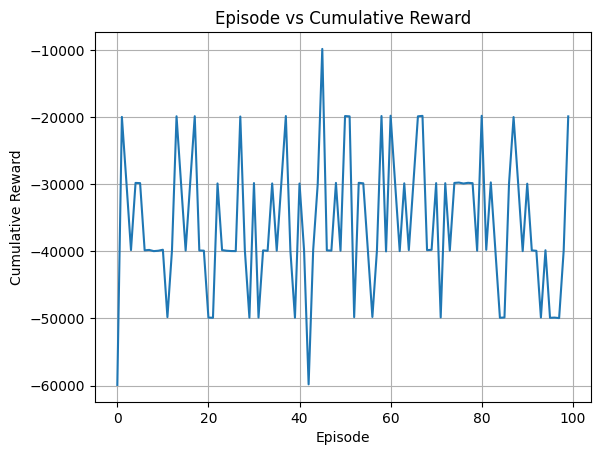

In [1]:
from typing import Dict, List, Optional, Tuple

import gymnasium as gym
import numpy as np
from numpy import typing as npt
import matplotlib.pyplot as plt  # Added import for plotting

class ModTSP(gym.Env):
    """Travelling Salesman Problem (TSP) RL environment for maximizing profits.

    The agent navigates a set of targets based on precomputed distances. It aims to visit
    all targets to maximize profits. The profits decay with time.
    """

    def __init__(
        self,
        num_targets: int = 10,
        max_area: int = 15,
        shuffle_time: int = 10,
        seed: int = 42,
    ) -> None:
        """Initialize the TSP environment.

        Args:
            num_targets (int): Number of targets the agent needs to visit.
            max_area (int): Maximum square area where the targets are defined.
            shuffle_time (int): Number of episodes after which the profits are to be shuffled.
            seed (int): Random seed for reproducibility.
        """
        super().__init__()

        np.random.seed(seed)

        self.steps: int = 0
        self.episodes: int = 0

        self.shuffle_time: int = shuffle_time
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: npt.NDArray[np.float32] = self._generate_points(self.num_targets)
        self.distances: npt.NDArray[np.float32] = self._calculate_distances(self.locations)

        # Initialize profits for each target
        self.initial_profits: npt.NDArray[np.float32] = np.arange(1, self.num_targets + 1, dtype=np.float32) * 10.0
        self.current_profits: npt.NDArray[np.float32] = self.initial_profits.copy()

        # Observation Space: {current loc, target flags, current profits, distances, coordinates}
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),  # Current location
                np.zeros(self.num_targets, dtype=np.float32),  # Visited targets
                np.zeros(self.num_targets, dtype=np.float32),  # Current profits
                np.zeros(self.num_targets, dtype=np.float32),  # Distances
                np.zeros(2 * self.num_targets, dtype=np.float32),  # Coordinates
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),  # Current location
                np.ones(self.num_targets, dtype=np.float32),  # Visited targets
                100 * np.ones(self.num_targets, dtype=np.float32),  # Current profits
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),  # Distances
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),  # Coordinates
            ]
        )

        # Action Space: {next_target}
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[np.ndarray, Dict[str, None]]:
        """Reset the environment to the initial state.

        Args:
            seed (Optional[int], optional): Seed to reset the environment. Defaults to None.
            options (Optional[dict], optional): Additional reset options. Defaults to None.

        Returns:
            Tuple[np.ndarray, Dict[str, None]]: The initial state of the environment and an empty info dictionary.
        """
        self.steps: int = 0
        self.episodes += 1

        self.loc: int = 0
        self.visited_targets: npt.NDArray[np.float32] = np.zeros(self.num_targets)
        self.current_profits = self.initial_profits.copy()
        self.dist: List = self.distances[self.loc]

        if self.shuffle_time % self.episodes == 0:
            np.random.shuffle(self.initial_profits)

        state = np.concatenate(
            (
                np.array([self.loc]),
                self.visited_targets,
                self.initial_profits,
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """Take an action (move to the next target).

        Args:
            action (int): The index of the next target to move to.

        Returns:
            Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
                - The new state of the environment.
                - The reward for the action.
                - A boolean indicating whether the episode has terminated.
                - A boolean indicating if the episode is truncated.
                - An empty info dictionary.
        """
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        self.current_profits -= self.distances[past_loc, next_loc]
        reward = self._get_rewards(next_loc)

        self.visited_targets[next_loc] = 1

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                self.visited_targets,
                self.current_profits,
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> npt.NDArray[np.float32]:
        """Generate random 2D points representing target locations.

        Args:
            num_points (int): Number of points to generate.

        Returns:
            np.ndarray: Array of 2D coordinates for each target.
        """
        return np.random.uniform(low=0, high=self.max_area, size=(num_points, 2)).astype(np.float32)

    def _calculate_distances(self, locations: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        """Calculate the distance matrix between all target locations.

        Args:
            locations: List of 2D target locations.

        Returns:
            np.ndarray: Matrix of pairwise distances between targets.
        """
        n = len(locations)

        distances = np.zeros((n, n), dtype=np.float32)
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, next_loc: int) -> float:
        """Calculate the reward based on the distance traveled. If a target gets visited again, it incurs a high penalty.

        Args:
            next_loc (int): Next location of the agent.

        Returns:
            float: Reward based on the travel distance between past and next locations, or negative reward if revisiting.
        """
        reward = self.current_profits[next_loc] if not self.visited_targets[next_loc] else -1e4
        return float(reward)


def main() -> None:
    """Main function."""
    num_targets = 10

    env = ModTSP(num_targets)
    obs, _ = env.reset()
    ep_rets = []

    for ep in range(100):
        ret = 0
        obs, _ = env.reset()
        for _ in range(100):
            action = env.action_space.sample()  # Replace this with your algorithm that predicts the action.

            obs_, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            ret += reward

            if done:
                break

        ep_rets.append(ret)
        # print(f"Episode {ep} : {ret}")

    # Plot the episode vs cumulative reward
    plt.plot(range(len(ep_rets)), ep_rets)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Episode vs Cumulative Reward')
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    main()
